# Tidy3D first walkthrough

Our first tutorial focuses on illustrating the basic setup, run, and analysis of a ``Tidy3D`` simulation. In this example, we will simulate a plane wave impinging on dielectric slab with a triangular pillar made of a lossy dielectric sitting on top. First, we import everything needed.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import h5py

# tidy3d imports
import tidy3d as td
from tidy3d import web


First, we initialize some general simulation parameters. We note that the PML layers extend **beyond** the simulation domain, making the total simulation size larger - as opposed to some solvers in which the PML is covering part of the user-defined simulation domain.

In [2]:
# Simulation domain size (in micron)
sim_size = [4, 4, 4]

# Central frequency and bandwidth of pulsed excitation, in Hz
freq0 = 2e14
fwidth = 1e13

# apply a PML in all directions
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())


The run time of a simulation depends a lot on whether there are any long-lived resonances. In our example here, there is no strong resonance. Thus, we do not need to run the simulation much longer than after the sources have decayed. We thus set the run time based on the source bandwidth.

In [3]:
# Total time to run in seconds
run_time = 2 / fwidth


### Structures and materials

Next, we initialize the simulated structure. The structure consists of two [Structure](../_autosummary/tidy3d.Structure.html) objects. Each object consists of a [Geometry](../api.html#geometry) and a [Medium](../api.html#mediums)  to define the spatial extent and material properties, respectively. Note that the size of any object (structure, source, or monitor) can extend beyond the simulation domain, and is truncated at the edges of that domain. 

Note: For best results, structures that intersect with the PML or simulation edges should extend extend all the way through. In many such cases, an "infinite" size `td.inf` can be used to define the size along that dimension.

In [4]:
# Lossless dielectric specified directly using relative permittivity
material1 = td.Medium(permittivity=6.0)

# Lossy dielectric defined from the real and imaginary part of the refractive index
material2 = td.Medium.from_nk(n=1.5, k=0.0, freq=freq0)
# material2 = td.Medium(permittivity=2.)


# Rectangular slab, extending infinitely in x and y with medium `material1`
box = td.Structure(
    geometry=td.Box(center=[0, 0, 0], size=[td.inf, td.inf, 1]), medium=material1
)

# Triangle in the xy-plane with a finite extent in z
equi_tri_verts = [[-1 / 2, -1 / 4], [1 / 2, -1 / 4], [0, np.sqrt(3) / 2 - 1 / 4]]

poly = td.Structure(
    geometry=td.PolySlab(
        vertices=(2 * np.array(equi_tri_verts)).tolist(),
        # vertices=equi_tri_verts,
        slab_bounds=(0.5, 1.0),
        axis=2,
    ),
    medium=material2,
)


### Sources

Next, we define a source injecting a normal-incidence plane-wave from above. The time dependence of the source is a Gaussian pulse. A source can be added to multiple simulations. After we add the source to a specific simulation, such that the total run time is known, we can use in-built plotting tools to visualize its time- and frequency-dependence, which we will show below.

In [5]:
psource = td.PlaneWave(
    center=(0, 0, 1.5),
    direction="-",
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    pol_angle=np.pi / 2,
)


### Monitors

Finally, we can also add some monitors that will record the fields that we request during the simulation run. 

The two monitor types for measuring fields are [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) and [FieldTimeMonitor](../_autosummary/tidy3d.FieldTimeMonitor.html), which record the frequency-domain and time-domain fields, respectively.  

[FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) objects operate by running a discrete Fourier transform of the fields at a given set of frequencies to perform the calculation "in-place" with the time stepping. [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) objects are useful for investigating the steady-state field distribution in 2D or even 3D regions of the simulation.

[FieldTimeMonitor](../_autosummary/tidy3d.FieldTimeMonitor.html) objects are best used to monitor the time dependence of the fields at a single point, but they can also be used to create "animations" of the field pattern evolution. Because spatially large [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) objects can lead to a very large amount of data that needs to be stored, an optional start and stop time can be supplied, as well as an `interval` specifying the amount of time steps between each measurement (default of 1).

In [6]:
# measure time domain fields at center location, measure every 5 time steps
time_mnt = td.FieldTimeMonitor(
    center=[0, 0, 0], size=[0, 0, 0], interval=5, name="field_time"
)

# measure the steady state fields at central frequency in the xy plane and the xz plane.
freq_mnt1 = td.FieldMonitor(
    center=[0, 0, -1], size=[20, 20, 0], freqs=[freq0], name="field1"
)
freq_mnt2 = td.FieldMonitor(
    center=[0, 0, 0], size=[20, 0, 20], freqs=[freq0], name="field2"
)


[16:43:59] WARNING: Default value for the field monitor           ]8;id=327133;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=813515;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=859902;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=70180;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

           WARNING: Default value for the field monitor           ]8;id=881996;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=832872;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

### Simulation

Now we can initialize the [Simulation](../_autosummary/tidy3d.Simulation.html) with all the elements defined above. A nonuniform simulation grid is generated automatically based on a given minimum number of cells per wavelength in each material (10 by default), using the frequencies defined in the source.

In [7]:
# Initialize simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20),
    structures=[box, poly],
    sources=[psource],
    monitors=[time_mnt, freq_mnt1, freq_mnt2],
    run_time=run_time,
    boundary_spec=boundary_spec,
)


We can check the simulation monitors just to make sure everything looks right.

In [8]:
for m in sim.monitors:
    m.help()


╭───────────── <class 'tidy3d.components.monitor.FieldTimeMonitor'> ─────────────╮
│ :class:`Monitor` that records electromagnetic fields in the time domain.       │
│                                                                                │
│ ╭────────────────────────────────────────────────────────────────────────────╮ │
│ │ FieldTimeMonitor(                                                          │ │
│ │ │   type='FieldTimeMonitor',                                               │ │
│ │ │   center=(0.0, 0.0, 0.0),                                                │ │
│ │ │   size=(0.0, 0.0, 0.0),                                                  │ │
│ │ │   name='field_time',                                                     │ │
│ │ │   interval_space=(1, 1, 1),                                              │ │
│ │ │   colocate=True,                                                         │ │
│ │ │   start=0.0,                                                             │ │
│ │ │   stop=None,                                                             │ │
│ │ │   interval=5,                                                            │ │
│ │ │   fields=('Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz')                            │ │
│ │ )                                                                          │ │
│ ╰────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                │
│   bounding_box = Box(type='Box', center=(0.0, 0.0, 0.0), size=(0.0, 0.0, 0.0)) │
│         bounds = ((0.0, 0.0, 0.0), (0.0, 0.0, 0.0))                            │
│         center = (0.0, 0.0, 0.0)                                               │
│       colocate = True                                                          │
│         fields = ('Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz')                          │
│       geometry = Box(type='Box', center=(0.0, 0.0, 0.0), size=(0.0, 0.0, 0.0)) │
│       interval = 5                                                             │
│ interval_space = (1, 1, 1)                                                     │
│           name = 'field_time'                                                  │
│    plot_params = PlotParams(                                                   │
│                      alpha=0.4,                                                │
│                      edgecolor='orange',                                       │
│                      facecolor='orange',                                       │
│                      fill=True,                                                │
│                      hatch=None,                                               │
│                      linewidth=3.0,                                            │
│                      type='PlotParams'                                         │
│                  )                                                             │
│           size = (0.0, 0.0, 0.0)                                               │
│          start = 0.0                                                           │
│           stop = None                                                          │
│           type = 'FieldTimeMonitor'                                            │
│      zero_dims = [0, 1, 2]                                                     │
╰────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────── <class 'tidy3d.components.monitor.FieldMonitor'> ───────────────────────╮
│ :class:`Monitor` that records electromagnetic fields in the frequency domain.                  │
│                                                                                                │
│ ╭────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ FieldMonitor(                                                                              │ │
│ │ │   type='FieldMonitor',                                                                   │ │
│ │ │   center=(0.0, 0.0, -1.0),                                                               │ │
│ │ │   size=(20.0, 20.0, 0.0),                                                                │ │
│ │ │   name='field1',                                                                         │ │
│ │ │   interval_space=(1, 1, 1),                                                              │ │
│ │ │   colocate=True,                                                                         │ │
│ │ │   freqs=(200000000000000.0,),                                                            │ │
│ │ │   apodization=ApodizationSpec(                                                           │ │
│ │ │   │   start=None,                                                                        │ │
│ │ │   │   end=None,                                                                          │ │
│ │ │   │   width=None,                                                                        │ │
│ │ │   │   type='ApodizationSpec'                                                             │ │
│ │ │   ),                                                                                     │ │
│ │ │   fields=('Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz')                                            │ │
│ │ )                                                                                          │ │
│ ╰────────────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                                │
│     apodization = ApodizationSpec(start=None, end=None, width=None, type='ApodizationSpec')    │
│    bounding_box = Box(type='Box', center=(0.0, 0.0, -1.0), size=(20.0, 20.0, 0.0))             │
│          bounds = ((-10.0, -10.0, -1.0), (10.0, 10.0, -1.0))                                   │
│          center = (0.0, 0.0, -1.0)                                                             │
│        colocate = True                                                                         │
│          fields = ('Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz')                                         │
│           freqs = (200000000000000.0,)                                                         │
│ frequency_range = (200000000000000.0, 200000000000000.0)                                       │
│        geometry = Box(type='Box', center=(0.0, 0.0, -1.0), size=(20.0, 20.0, 0.0))             │
│  interval_space = (1, 1, 1)                                                                    │
│            name = 'field1'                                                                     │
│     plot_params = PlotParams(                                                                  │
│                       alpha=0.4,                                                               │
│                       edgecolor='orange',                                                      │
│                       facecolor='orange',                                                      │
│                       fill=True,                                                               │
│                       hatch=None,                                                              │
│                       linewidth=3.0,                                                           │
│                       type='PlotParams

╭─────────────────────── <class 'tidy3d.components.monitor.FieldMonitor'> ───────────────────────╮
│ :class:`Monitor` that records electromagnetic fields in the frequency domain.                  │
│                                                                                                │
│ ╭────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ FieldMonitor(                                                                              │ │
│ │ │   type='FieldMonitor',                                                                   │ │
│ │ │   center=(0.0, 0.0, 0.0),                                                                │ │
│ │ │   size=(20.0, 0.0, 20.0),                                                                │ │
│ │ │   name='field2',                                                                         │ │
│ │ │   interval_space=(1, 1, 1),                                                              │ │
│ │ │   colocate=True,                                                                         │ │
│ │ │   freqs=(200000000000000.0,),                                                            │ │
│ │ │   apodization=ApodizationSpec(                                                           │ │
│ │ │   │   start=None,                                                                        │ │
│ │ │   │   end=None,                                                                          │ │
│ │ │   │   width=None,                                                                        │ │
│ │ │   │   type='ApodizationSpec'                                                             │ │
│ │ │   ),                                                                                     │ │
│ │ │   fields=('Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz')                                            │ │
│ │ )                                                                                          │ │
│ ╰────────────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                                │
│     apodization = ApodizationSpec(start=None, end=None, width=None, type='ApodizationSpec')    │
│    bounding_box = Box(type='Box', center=(0.0, 0.0, 0.0), size=(20.0, 0.0, 20.0))              │
│          bounds = ((-10.0, 0.0, -10.0), (10.0, 0.0, 10.0))                                     │
│          center = (0.0, 0.0, 0.0)                                                              │
│        colocate = True                                                                         │
│          fields = ('Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz')                                         │
│           freqs = (200000000000000.0,)                                                         │
│ frequency_range = (200000000000000.0, 200000000000000.0)                                       │
│        geometry = Box(type='Box', center=(0.0, 0.0, 0.0), size=(20.0, 0.0, 20.0))              │
│  interval_space = (1, 1, 1)                                                                    │
│            name = 'field2'                                                                     │
│     plot_params = PlotParams(                                                                  │
│                       alpha=0.4,                                                               │
│                       edgecolor='orange',                                                      │
│                       facecolor='orange',                                                      │
│                       fill=True,                                                               │
│                       hatch=None,                                                              │
│                       linewidth=3.0,                                                           │
│                       type='PlotParams

### Visualization functions

We can now use the some in-built plotting functions to make sure that we have set up the simulation as we desire.

First, let's take a look at the source time dependence.

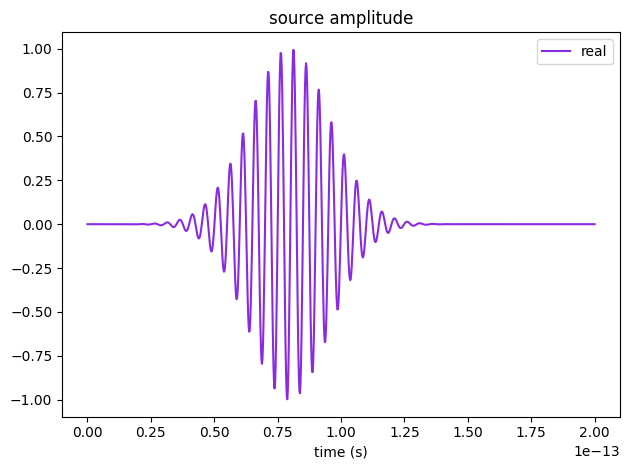

In [9]:
# Visualize source
psource.source_time.plot(np.linspace(0, run_time, 1001))
plt.show()


And now let's visualize the simulation. 

For this, we will plot three cross sections at `z=0.75`, `y=0`, and `x=0`, respectively. 

The relative permittivity of objects is plotted in greyscale.

By default, sources are overlayed in green, monitors in yellow, and PML boundaries in grey.

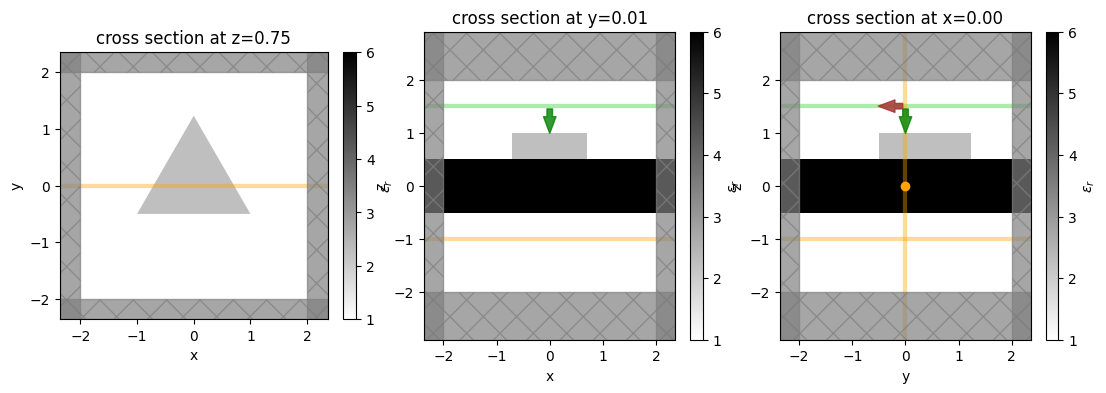

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
sim.plot_eps(z=0.75, freq=freq0, ax=ax[0])
sim.plot_eps(y=0.01, freq=freq0, ax=ax[1])
sim.plot_eps(x=0, freq=freq0, ax=ax[2])
plt.show()


Alternatively, we can also plot the structures with a fake color based on the material they are made of.

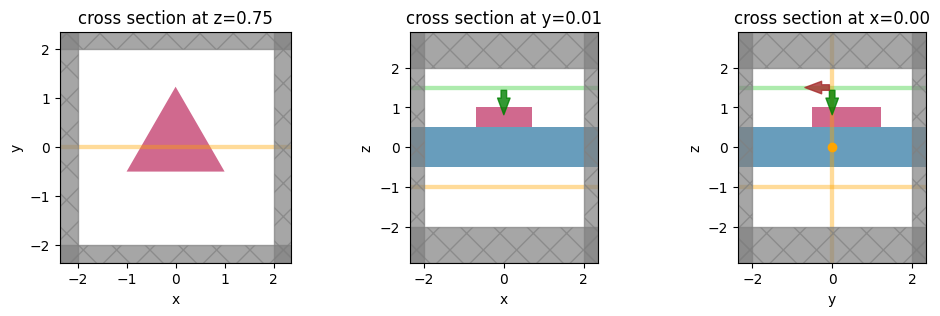

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sim.plot(z=0.75, ax=ax[0])
sim.plot(y=0.01, ax=ax[1])
sim.plot(x=0, ax=ax[2])
plt.show()


### Running through the web API

Now that the simulation is constructed, we can run it using the [web](../api.html#submitting-simulations) API of ``Tidy3D``. First, we submit the project. Note that we can give it a custom name.

In [12]:
task_id = web.upload(sim, task_name="Simulation")


[16:44:01] Created task 'Simulation' with task_id                  ]8;id=63825;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=990667;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-4354ac32-ac4c-4137-a1ca-6cd4fe2f8baev1'.                       

           View task using web UI at                               ]8;id=992146;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=646142;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=502461;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4354ac32-ac4c-4137-a1ca-6cd4fe2f8baev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=516123;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4354ac32-ac4c-4137-a1ca-6cd4fe2f8baev1\taskId]8;;\]8;id=502461;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4354ac32-ac4c-4137-a1ca-6cd4fe2f8baev1\=]8;;\]8;id=414538;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4354ac32-ac4c-4137-a1ca-6cd4fe2f8baev1\fdve]8;;\]8;id=502461;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4354ac32-ac4c-4137-a1ca-6cd4fe2f8baev1\-]8;;\              
           ]8;id=502461;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4354ac32-ac4c-4137-a1ca-6cd4fe2f8baev1\4354ac32-ac4c-4137-a1ca-6cd4fe2f8baev1']8;;\.                             

Output()

The task is still in draft status and will not run until we call the start function. Before that, we may want to check the estimated cost of the task. This is the maximum possible cost, and can be lower in case of early shutoff.

In [13]:
print("Max flex unit cost: ", web.estimate_cost(task_id))


Max flex unit cost:  0.025


We can now start the task, and if we want to, continously monitor its status, and wait until the run is successful. The [monitor](../_autosummary/tidy3d.web.monitor.html#tidy3d.web.monitor) function will keep running until either a `'success'` or `'error'` status is returned.

In [14]:
web.start(task_id)
web.monitor(task_id, verbose=True)


[16:44:08] status = queued                                         ]8;id=210115;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=225109;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[16:44:29] status = preprocess                                     ]8;id=305922;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=709875;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[16:44:33] Maximum FlexCredit cost: 0.025. Use                     ]8;id=421522;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=257668;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=417260;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=940487;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=616081;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=71889;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=964191;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=199412;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[16:44:41] early shutoff detected, exiting.                        ]8;id=700810;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=545251;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=217683;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=392535;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

We can also use the ``real_cost`` function once the task is complete to check the cost that was actually billed. It may take a few seconds before it is available.

In [15]:
import time

time.sleep(4)
print("Billed flex unit cost: ", web.real_cost(task_id))


Billed flex unit cost:  0.025


## Loading and analyzing data

After a successful run, we can download the results and load them into our simulation model. We use the `download_results` function from our web API, which downloads a single `hdf5` file containing all the monitor data, a log file, and a `json` file defining the original simulation (same as what you'll get if you run `sim.to_json()` on the current object). Optionally, you can provide a folder in which to store the files. In the example below, the results are stored in the `data/` folder. 

In [16]:
sim_data = web.load(task_id, path="data/sim_data.hdf5")

# Show the output of the log file
print(sim_data.log)


Output()

[16:44:52] loading SimulationData from data/sim_data.hdf5          ]8;id=878863;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=981191;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\

Simulation domain Nx, Ny, Nz: [156, 157, 104]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 2.6629e+06.
Using subpixel averaging: True
Number of time steps: 3.4930e+03
Automatic shutoff factor: 1.00e-05
Time step (s): 5.7275e-17


Compute source modes time (s):     0.1589
Compute monitor modes time (s):    0.0024
Rest of setup time (s):            3.3259

Running solver for 3493 time steps...
- Time step    139 / time 7.96e-15s (  4 % done), field decay: 1.00e+00
- Time step    279 / time 1.60e-14s (  8 % done), field decay: 1.00e+00
- Time step    419 / time 2.40e-14s ( 12 % done), field decay: 1.00e+00
- Time step    558 / time 3.20e-14s ( 16 % done), field decay: 1.00e+00
- Time step    698 / time 4.00e-14s ( 20 % done), field decay: 1.00e+00
- Time step    838 / time 4.80e-14s ( 24 % done), field decay: 1.00e+00
- Time step    978 / time 5.60e-14s ( 28 % done), field decay: 1.00e+00
- Time step   1117 / time 6.40e-14s ( 32 % done), field decay: 1.00e+00
- Time 

### Visualization functions

Finally, we can now use the in-built visualization tools to examine the results. Below, we plot the `y`-component of the field recorded by the two frequency monitors (this is the dominant component since the source is `y`-polarized).

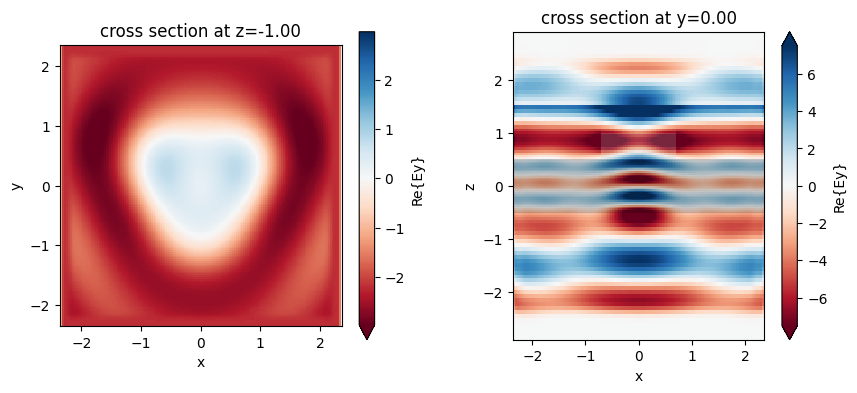

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sim_data.plot_field("field1", "Ey", z=-1.0, ax=ax[0], val="real")
sim_data.plot_field("field2", "Ey", ax=ax[1], val="real")
plt.show()


### Monitor data
The raw field data can be accessed through indexing by monitor name directly.

For plenty of discussion on accessing and manipulating data, refer to the [data visualization tutorial](../notebooks/VizData.html).

In [18]:
mon1_data = sim_data["field1"]
mon1_data.Ex


<xarray.ScalarFieldDataArray (x: 157, y: 158, z: 1, f: 1)>
array([[[[ 0.00000000e+00+0.0000000e+00j]],

        [[ 9.95676146e-07+4.0475229e-07j]],

        [[ 6.85613168e-06+2.1606543e-06j]],

        ...,

        [[ 9.21844332e-07+1.4098153e-07j]],

        [[ 6.94892037e-08+7.4889490e-09j]],

        [[ 0.00000000e+00+0.0000000e+00j]]],


       [[[ 0.00000000e+00+0.0000000e+00j]],

        [[ 4.36889559e-06+1.5265606e-06j]],

        [[ 3.08577437e-05+1.3333779e-05j]],
...
        [[-4.72412438e-07-3.9206373e-08j]],

        [[-2.63805742e-08-5.9617911e-09j]],

        [[ 0.00000000e+00+0.0000000e+00j]]],


       [[[ 0.00000000e+00+0.0000000e+00j]],

        [[-1.09413044e-07+7.5178157e-09j]],

        [[-4.62539788e-07+5.2695871e-08j]],

        ...,

        [[-2.65202527e-08-1.2353234e-08j]],

        [[-2.18450538e-08-3.1581589e-08j]],

        [[ 0.00000000e+00+0.0000000e+00j]]]], dtype=complex64)
Coordinates:
  * x        (x) float64 -2.364 -2.333 -2.303 -2.273 ... 2.273 2.303 2.333 2.364
  * y        (y) float64 -2.36 -2.33 -2.3 -2.27 ... 2.266 2.295 2.325 2.354
  * z        (z) float64 -1.0
  * f        (f) float64 2e+14
Attributes:
    long_name:  field value

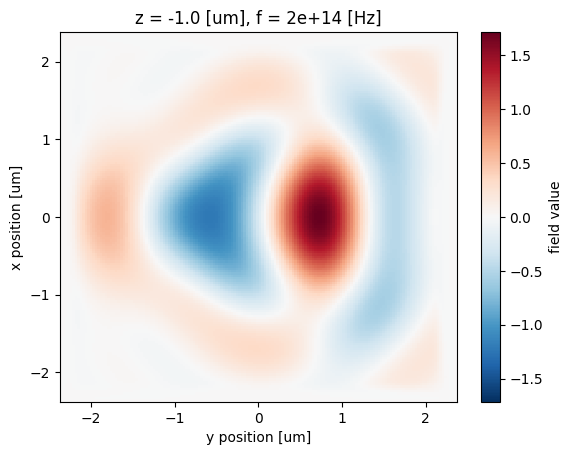

In [19]:
ax = mon1_data.Ez.real.plot()


We can use this raw data for example to also plot the time-domain fields recorded in the [FieldTimeMonitor](../_autosummary/tidy3d.FieldTimeMonitor.html), which look largely like a delayed version of the source input, indicating that no resonant features were excited.

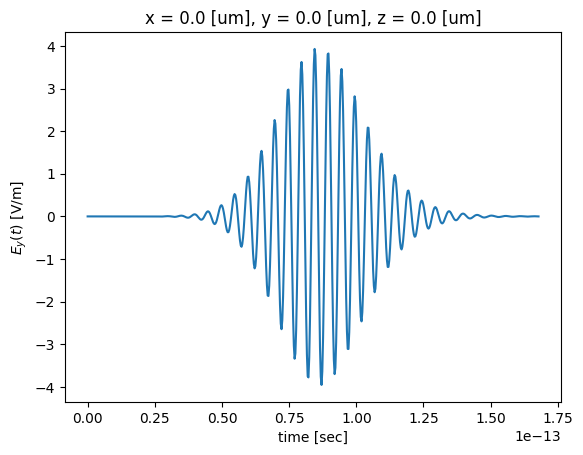

In [20]:
time_data = sim_data["field_time"]
fig, ax = plt.subplots(1)
time_data.Ey.plot()
ax.set_ylabel("$E_y(t)$ [V/m]")
plt.show()


### Permittivity data

We can also query the relative permittivity in the simulation within a volume parameterized by a `td.Box`. The method `Simulation.epsilon(box, coord_key)` returns the permittivity within the specified volume.

The `coord_key` specifies at what locations in the yee cell to evaluate the permittivity at (eg. `'centers'`, `'Ey'`, `'Hz'`, etc.).

In [21]:
volume = td.Box(center=(0, 0, 0.75), size=(5, 5, 0))

# at Yee cell centers
eps_centers = sim.epsilon(box=volume, coord_key="centers")

# at Ex locations in the yee cell
eps_Ex = sim.epsilon(box=volume, coord_key="Ex")


Return an xarray DataArray containing the complex-valued permittivity values at the Yee cell centers and the "Ex" within the [box](../_autosummary/tidy3d.Box.html).

We can then plot or post-process this data as we wish.

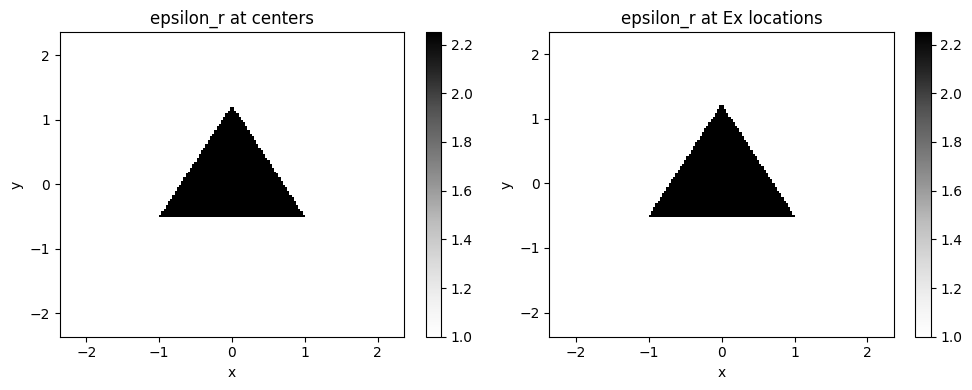

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))

eps_centers.real.plot(x="x", y="y", cmap="Greys", ax=ax1)
eps_Ex.real.plot(x="x", y="y", cmap="Greys", ax=ax2)
ax1.set_title("epsilon_r at centers")
ax2.set_title("epsilon_r at Ex locations")

plt.show()


For simulation examples, please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials.